# Support Vector Machines and a short introduction to kernel theory

1. [A geometrical approach to Machine Learning: margin maximization](#sec1)
2. [Support Vector Machines in scikit-learn](#sec2)
3. [When using linear separators makes no more sense](#sec3)
4. [A word on the bias-variance compromise](#sec4)
5. [The kernel trick](#sec5)
6. [SVMs and kernels](#sec6)
7. [What about other uses?](#sec7)
8. [Examples](#sec8)
    1. [Spam or ham?](#sec8-1)
    2. [NIST](#sec8-2)

<div class="alert alert-success">
    
**In a nutshell:**
    
- Support Vector Machines try to separate data by maximizing a geometrical margin
- They are computed offline
- They offer a sparse, robust to class imbalance, and easy to evaluate predictor
- Kernels are a way of enriching (lifting) the data representation so that it becomes linearly separable
- SVMs + kernels offer a versatile method for classification, regression and density estimation
- [Documentation in scikit-learn](http://scikit-learn.org/stable/modules/svm.html)
</div>

## <a id="sec1"></a> 1. A geometrical approach to Machine Learning

Suppose we are given the dataset $\{(x_i,y_i)\}$ below.

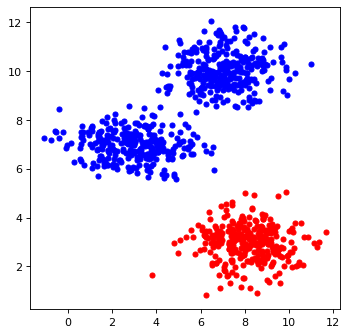

In [1]:
import numpy as np
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
fig_size=(5, 5)

res = np.loadtxt("sep_lin.csv", delimiter=',')
X = res[:,0:-1]
y = res[:,-1].astype(int)
Xblue = X[y==-1]
Xred = X[y==1]

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20);

<div class="alert alert-warning">
    
**Question**<br>
<ul>
<li> What constitutes a "good" separating line between red and blue dots?
<li> What about the lines below?
</ul>
</div>

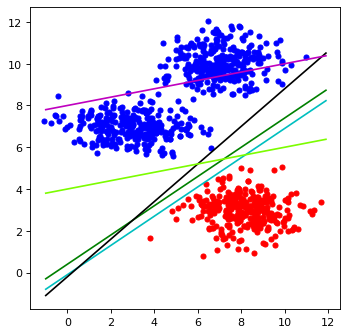

In [2]:
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = 0.7*XX+0.4
plt.plot(XX,YY,c='g')
YY = 0.7*XX-0.1
plt.plot(XX,YY,c='c')
YY = 0.9*XX-0.2
plt.plot(XX,YY,c='k')
YY = 0.2*XX+4
plt.plot(XX,YY,c='lawngreen')
YY = 0.2*XX+8
plt.plot(XX,YY,c='m');

The best separating hyperplane is the one that maximizes the distance to the closest points. Let's write $M$ this distance and call it **the margin**.

\begin{equation*}
M = \min_i y_i(w^Tx_i + w_0)
\end{equation*}

<div class="alert alert-warning">
    
**Question**<br>
What is the margin of the dark green line in the example above?
</div>
To answer this question, recall that given a hyperplane of equation $w^Tx + w_0=0$, with $\|w\|=1$, the (signed) distance between $x_i$ and the hyperplane is precisely $w^Tx_i + w_0$.

In [3]:
w = np.array([0.7, -1])
w = w/np.linalg.norm(w)
w0 = 0.4
M = y*(np.dot(X,w) + w0)
print("margin =", np.min(M))

margin = 0.5823203757923597


We want to find the hyperplane that maximizes the margin, so:
\begin{gather*}
\max_{M,w,w_0} M\\
y_i(w^Tx_i + w_0) \geq M, \forall i \in [1,N] \\
\|w\| = 1
\end{gather*}
Let's use some optimization routines for that.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7226638108562764
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
[ 0.72266381  0.42124178 -0.90694838  1.88363065]
margin = 0.7226638108562764


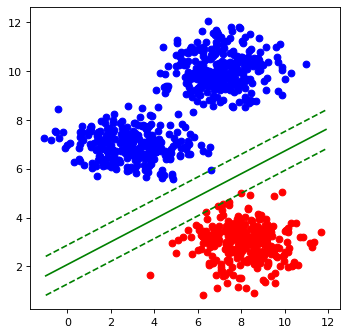

In [4]:
import scipy.optimize as sopt

def func(x):
    """x = (M,w_1,w_2,b)"""
    return -x[0]

def ineq_constr(x):
    """x = (M,w_1,w_2,b)"""
    return y*(x[1]*X[:,0] + x[2]*X[:,1] + x[3]*np.ones(X.shape[0])) - x[0]*np.ones(X.shape[0])

def eq_const(x):
    return x[1]*x[1]+x[2]*x[2]-1

x0 = np.array([0.,0.7,-1.,0.4])
res = sopt.fmin_slsqp(func, x0, f_eqcons=eq_const, f_ieqcons=ineq_constr)
print(res)
print("margin =", res[0])
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(res[1]*XX+res[3])/res[2]
plt.plot(XX,YY,c='g')
YY = -(res[1]*XX+res[3]+res[0])/res[2]
plt.plot(XX,YY,'g--')
YY = -(res[1]*XX+res[3]-res[0])/res[2]
plt.plot(XX,YY,'g--');

\begin{gather*}
\max_{M,w,w_0} M\\
y_i(w^Tx_i + w_0) \geq M, \forall i \in [1,N] \\
\|w\| = 1
\end{gather*}
is actually equivalent to finding $w$ and $w_0$ for:
\begin{gather*}\min_{w,w_0} \frac{1}{2}\|w\|^2\\
y_i (w^T x_i + w_0) \geq 1, \forall i \in [1,N]
\end{gather*}
(curious how we did that? just try the variable change $w' = \frac{w}{M}$ and $w'_0 = \frac{w_0}{M}$).

Let's check we obtain the same result.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9574087436846036
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
[ 2.60651025  0.58290145 -1.25500733]
margin = 0.7226638117587084


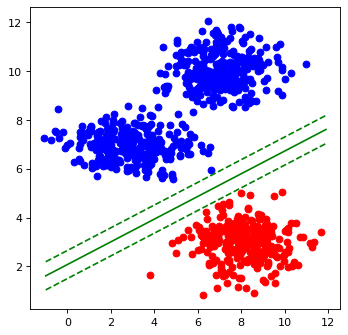

In [5]:
def func(w):
    """w=(w_0,w_1,w_2)"""
    return .5*(w[1]**2 + w[2]**2)

def ineq_constr(w):
    """w=(w_0,w_1,w_2)"""
    return y*(w[1]*X[:,0] + w[2]*X[:,1] + w[0]*np.ones(X.shape[0])) - np.ones(X.shape[0])

x0 = np.array([0.4,0.7,-1.])
res = sopt.fmin_slsqp(func, x0, f_ieqcons=ineq_constr)
print(res)
M = 1. / np.linalg.norm(np.array([res[1],res[2]]))
print("margin =", M)
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(res[1]*XX+res[0])/res[2]
plt.plot(XX,YY,c='g')
YY = -(res[1]*XX+res[0]+M)/res[2]
plt.plot(XX,YY,'g--')
YY = -(res[1]*XX+res[0]-M)/res[2]
plt.plot(XX,YY,'g--');

It appears that this optimization problem has interesting properties. In particular:
\begin{equation*}w = \sum_{i=1}^N \alpha_i y_i x_i\end{equation*}
with \begin{equation*}\alpha_i (y_i (w^T x_i + w_0)-1) = 0\end{equation*}

What does that mean in plain words?

<div class="alert alert-success">
    
The optimal separating hyperplane has a normal vector $w$ that is a **linear combination** of the data $x_i$.
</div>

Even better: $\alpha_i=0$ or $w^T x_i + w_0=1$. But $w^T x_i + w_0=1$ correspond to points that are **exactly on the margin's boundary**. For all points further than this boundary, necessarily $\alpha_i=0$. So the only $x_i$ that have non-zero $\alpha_i$ are these points that **define the margin**. We call them **support vectors**.

In the end, the optimal separating hyperplane's normal vector is defined as a linear combination of the support vectors' coordinates. This linear combination is **sparse**, it has few non-zero coefficients.

That's it, we've built our first SVM!

Ok, that's all very nice, but what if it is not possible to separate the data with a line, just as in the example below?

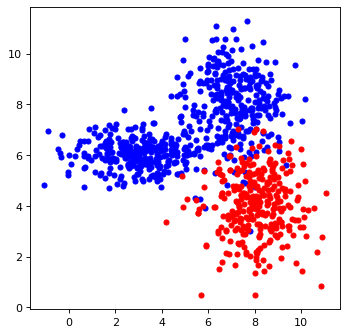

In [6]:
from sklearn import datasets
from sklearn.utils import shuffle

X1, y1 = datasets.make_gaussian_quantiles(cov=2.0, n_samples=300, n_features=2, n_classes=1)
X1[:,0] = 3. + X1[:,0]
X1[:,1] = 6. + X1[:,1]/2.5
X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X2[:,0] = 8. + X2[:,0]
X2[:,1] = 4. + X2[:,1]
X3, y3 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X3[:,0] = 7. + X3[:,0]
X3[:,1] = 8. + X3[:,1]
X = np.concatenate((X1, X2, X3))
y = np.concatenate((y1, - y2 + 1, y3))
y = 2*y-1
X, y = shuffle(X, y)
Xblue = X[y==-1]
Xred = X[y==1]

# Display
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)#, edgecolors='k')
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20);

We still would like to fit a line through the data, since we can assume the overlapping of the red and blue dots is due to noise. Well, in this case again, the optimal separating hyperplane can be found by making a **compromise** between the amount of misclassifications and the value of the margin.

For each pair $(x_i,y_i)$, we introduce the variable $\xi_i$ that represents how far $x_i$ is on the wrong side of the margin's boundary, as illustrated by the figure below.

<img width="300px" src="non_lin_sep3.png">

We will just admit the optimization problem turns into:
\begin{equation*}
\begin{array}{c}
\min\limits_{w,w_0} \displaystyle\frac{1}{2}\|w\|^2 + C\sum\limits_{i=1}^N \xi_i\\
\text{ such that } \forall i=1..N, \left\{\begin{array}{l}
y_i\left(w^T x_i + w_0 \right)\geq 1-\xi_i, \\
\xi_i\geq 0
\end{array}\right.
\end{array}
\end{equation*}

Note that $C$ is the parameter that controls the trade-off between having a large margin and having few misclassified points.

So, suppose we solve this optimization problem and get $(w,w_0)$, how do we make a prediction on a new data point $x$? Simple! Just compute $w^T x + w_0$: if it's positive we are on one side of the classifier, otherwise we are on the other side.

## 2. <a id="sec2"></a>Support Vector Machines in scikit-learn

Fortunately for us, this optimization problem is solved is three lines in scikit-learn.

SV per class: [42 42]
w_i: [ 0.67136857 -1.47400527]
w_0: [3.6454731]
Margin: 0.6173983766130119
w^T x0 + w_0: [1.49402114]
w^T x1 + w_0: [0.66811752]
w^T x2 + w_0: [-0.4218822]


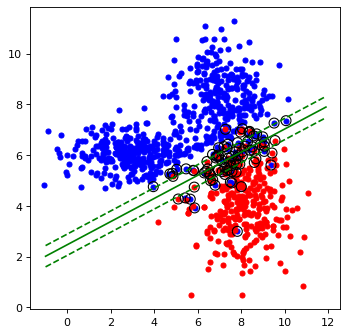

In [7]:
from sklearn import svm
mySVC = svm.SVC(kernel='linear', C=100)
mySVC.fit(X,y)

# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')
plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, edgecolors='k', facecolors='none');

<div class="alert alert-warning">
    
**Exercice**<br>
Try different values for $C$ in the code above to see how the margin's boundaries evolve.
</div>

Remark: since the optimization problem behind SVMs requires the knowledge of the full dataset, SVMs are necessarily an offline method.

Let's plot how the number of support vectors change with $C$.

Recall, there are 600 blue points and 300 red points.
Training at C = 0.0001
Training at C = 0.001
Training at C = 0.01
Training at C = 0.1
Training at C = 1.0
Training at C = 10.0
Training at C = 100.0
Training at C = 1000.0
Training at C = 10000.0
Training at C = 100000.0
Training at C = 1000000.0


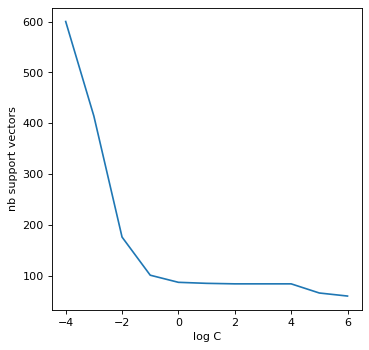

In [8]:
print("Recall, there are", Xblue.shape[0], "blue points and", Xred.shape[0], "red points.")
logC = np.arange(-4,7,1)
nbSV = np.zeros(len(logC))
for i in range(len(logC)):
    print("Training at C =", 10.**logC[i])
    mySVC = svm.SVC(kernel='linear', C=10.**logC[i])
    mySVC.fit(X,y)
    nbSV[i] = np.sum(mySVC.n_support_)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(logC,nbSV)
plt.xlabel("log C")
plt.ylabel("nb support vectors");

Let's make a few predictions.

SV per class: [43 44]
w_i: [ 0.65927417 -1.40580331]
w_0: [3.33407928]
Margin: 0.6440329930559805
w^T x0 + w_0: [1.42585911]
w^T x1 + w_0: [0.66640168]
w^T x2 + w_0: [-0.97040879]
Prediction in [2 4] = -1
Prediction in [6 2] = 1
Prediction in [10  2] = 1


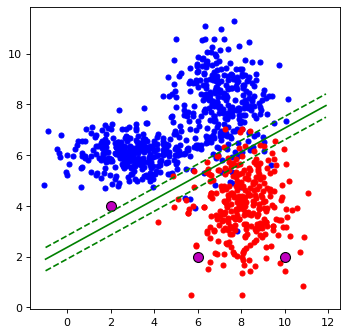

In [9]:
mySVC = svm.SVC(kernel='linear', C=1)
mySVC.fit(X,y)

# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')

# Testing data
Xtest = np.array([[2,4],[6,2],[10,2]])
Ypred = mySVC.predict(Xtest)
for i in range(Xtest.shape[0]):
    print("Prediction in", Xtest[i,:], "=", Ypred[i])

plt.scatter(Xtest[:,0],Xtest[:,1], c='m', edgecolors="k", s=80);

## <a id="sec3"></a>3. When using linear separators makes no more sense

Let's take a look at the following data. Would it make sense to try to separate the red points from the blue ones with a straight line?

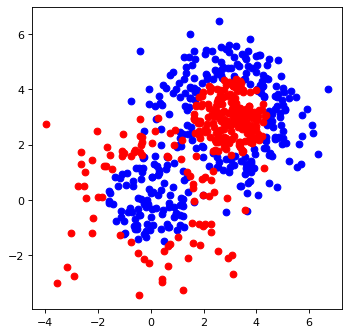

In [10]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r');

It does not look like a linear separation even makes sense. But let's try nonetheless, some optimal separating hyperplane must exist (even if it does not have great generalization properties).

SV per class: [299 288]
w_i: [-5.75753517e-05  7.37201260e-05]
w_0: [-1.00018167]
Margin: 10690.707418519069
w^T x0 + w_0: [-0.99999213]
w^T x1 + w_0: [-1.00022934]
w^T x2 + w_0: [-1.00021306]
Training score: 0.52


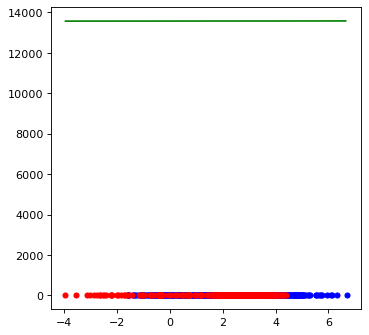

In [11]:
mySVC = svm.SVC(kernel='linear', C=1)
mySVC.fit(X,y)


# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1)
#XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
#YY = -(w[0]*XX+w0+M)/w[1]
#plt.plot(XX,YY,'g--')
#YY = -(w[0]*XX+w0-M)/w[1]
#plt.plot(XX,YY,'g--');
#plt.ylim(-6,10);
#plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, edgecolors='k', facecolors='none');
print("Training score:", mySVC.score(X,y))

Quite unconvincing, isn't it?

## <a id="sec4"></a>4. A word on the bias-variance compromise

The previous example is unconvincing mainly because we stubbornly look for a separator that has the shape of a straight line. Maybe if we allowed more flexibility, we could get better separators?

This compromise between flexibility and prior knowledge is called the **bias-variance** compromise in Machine Learning.
- If I search for a function that fits my data within a very restricted set of functions, I introduce a lot of expert knowledge, and thus a lot of **bias**, only allowing for little **variance** in the functions I might find.
- On the other hand, if I use a very rich family of functions, I abandon the introduction of priori information, allowing for high **variance** and low **bias**.

Although appealing, having high variance is not necessarily a good thing: looking for a function in a set that is just too rich leads to the risk of finding several almost equivalent functions that have great statistical properties but no physical meaning.

By maximizing the margin, SVMs actually try to minimize the variance of the family of functions considered: that is a way of trying to find the "simplest" function possible by minimizing $\|w\|$. This process is called **regularization** in Machine Learning. SVMs perform an $L_2$ regularization, but other forms of regularization exist and are commonly being used (e.g. $L_1$ regularization).

## <a id="sec5"></a>5. The kernel trick

Let's get back to the idea of giving more flexibility to our separator, since hyperplanes did not convince us they could always do the job.

To get around this problem, let's first introduce an illustrative example. The data below come from a voltage test in electronics. They indicate if a component fails or not under a certain voltage ($U$).

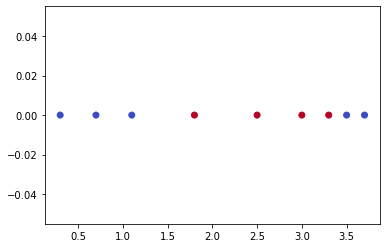

In [12]:
U = np.array([[0.3, 0.7, 1.1, 1.8, 2.5, 3.0, 3.3, 3.5, 3.7]]).T
Good = np.array( [[ -1,  -1,  -1,   1,   1,   1,   1,  -1,  -1]]).T
plt.figure()
plt.scatter(U, np.zeros((U.shape[0],1)), c=Good, cmap = plt.cm.coolwarm);

Does it look like these data are linearly separable?<br>
<br>
Some well-experienced engineer already knows that $U$ is no good criterion to split the data points into two categories with a single threshold (recall: in dimension 1, a hyperplane is a threshold). He also knows that other indicators like $V = (U-2)^2$ are not any better, but that the pair $(U,V)$ actually allows to build a separating line between points.

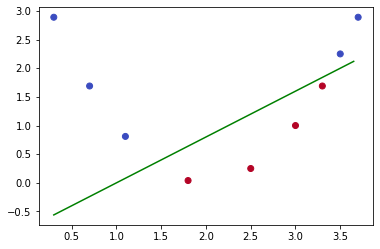

In [13]:
V = (2-U)**2
plt.figure()
plt.scatter(U, V, c=Good, cmap = plt.cm.coolwarm)
XX = np.arange(np.min(U), np.max(U), 0.05)
YY = -.8+.8*XX
plt.plot(XX,YY,'g');

Our nine points are now linearly separable. But we have not introduced any additional information!<br>
<br>
Actually, the only thing we have done, is to *map* our non-separable points $x$ into **another description space**, of higher dimension, where a linear separator exists.<br>
<br>
Suppose we happen to know such a relevant mapping for our data $\varphi(x)=x'$. Then we can compute the optimal linear separator in the corresponding higher dimension description space, find its parameters $w'$ and $w'_0$, and whenever we need to make a new prediction in a point $x$, we first compute its image $x'=\varphi(x)$ and then calculate $w'^T x' + w'_0$ to know on which side of the hyperplane we stand.

But recall that: \begin{equation*}w' = \sum_{i=1}^N \alpha_i y_i x'_i\end{equation*}

So :
\begin{align*}
w'^T x' + w'_0 & = \left(\sum_{i=1}^N \alpha_i y_i x'_i\right)^T \varphi(x) + w_0\\
& = \sum_{i=1}^N \alpha_i y_i \varphi(x_i)^T \varphi(x) + w'_0
\end{align*}

Suppose that, instead of providing is with a mapping $\varphi(x)=x'$, somebody gave us a function $K(x_1, x_2)$ that takes two points $x_1$ and $x_2$, computes their respective images $\varphi(x_1)$ and $\varphi(x_2)$ and returns the dot product:
\begin{equation*}K(x_1,x_2)=\varphi(x_1)^T \varphi(x_2)\end{equation*}

\begin{equation*}w'^T x' + w_0 = \sum_{i=1}^N \alpha_i y_i K(x_i,x) + w'_0\end{equation*}

The interesting thing is that we don't need to compute $\varphi$ anymore. The function $K$ is known as a **kernel function** and that's what we call the **kernel trick**.

It is actually possible to compute the $\alpha_i$ and $w'_0$ just using $K$ and never $\varphi$, so, as long as somebody insures that **the kernel $K$ is a dot product in some other descriptor space** we can compute the optimal separating hyperplane of our data in this space, **without ever requiring a knowledge of this descriptor space and the mapping $\varphi$**.

There are many kernels that have been developped in the litterature. Combined with what we have seen before, it allows to build non-linear SVMs. The nice thing is that some kernels actually map our data to a descriptor space of infinite dimension, where it is presumably a lot easier to find a separating hyperplane.

One such kernel is the so-called "radial basis kernel" which is very popular and can be written:
\begin{equation*}K(x_1,x_2) = e^{-\gamma \|x_1-x_2\|^2}\end{equation*}

## <a id="sec6"></a>6. SVMs and kernels

Let's practice on the last dataset with a radial basis kernel.

SV per class: [140 140]


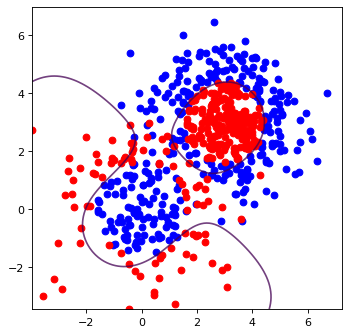

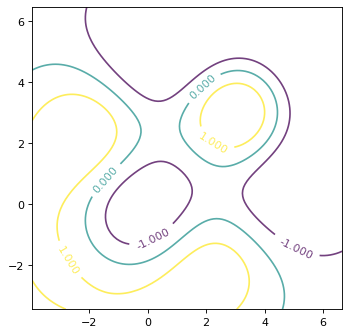

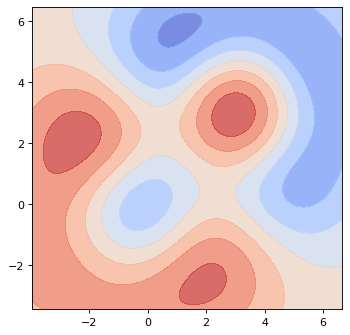

In [14]:
# Plot separator, margin and support vectors
def plot_SVC(mySVC):
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
    plt.scatter(Xred[:,0],Xred[:,1],c='r')
    XX, YY = np.meshgrid(np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1), np.arange(np.min(X[:,1]),np.max(X[:,1]),0.1))
    ZZ = mySVC.decision_function(np.c_[XX.ravel(), YY.ravel()])
    ZZ = ZZ.reshape(XX.shape)
    plt.contour(XX, YY, ZZ, levels=[0],alpha=0.75)
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    cont = plt.contour(XX, YY, ZZ, levels=[-1., 0., 1.], alpha=0.75)
    plt.clabel(cont, cont.levels, inline=True, fontsize=10)
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    cont = plt.contourf(XX, YY, ZZ, alpha=0.75, cmap = plt.cm.coolwarm)

# We can play with C
mySVC = svm.SVC(kernel='rbf', C=1.)
mySVC.fit(X,y)

print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC)

A lot better isn't it? Let's play a little with the value of $C$.

Let's see how that SVM with the rbf kernel would do on the data from the beginning of this notebook.

SV per class: [9 7]


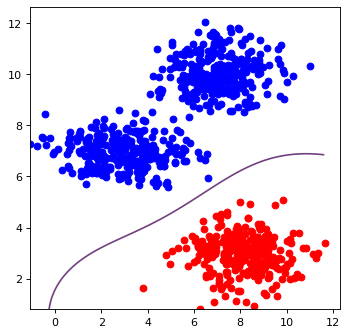

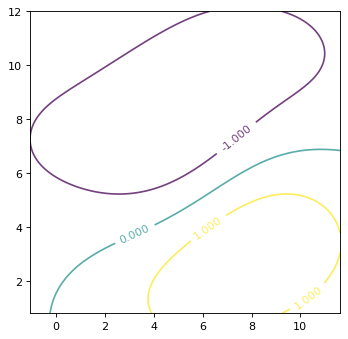

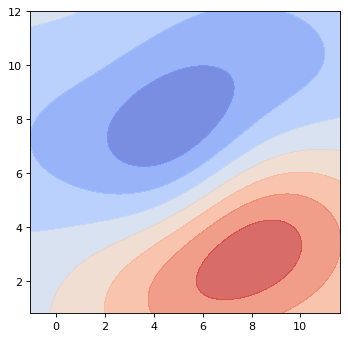

In [15]:
res = np.loadtxt("sep_lin.csv", delimiter=',')
X = res[:,0:-1]
y = res[:,-1].astype(int)
Xblue = X[y==-1]
Xred = X[y==1]

mySVC = svm.SVC(kernel='rbf')
mySVC.fit(X,y)
print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC);

And on the "linearly separable + noise" case?

SV per class: [56 52]


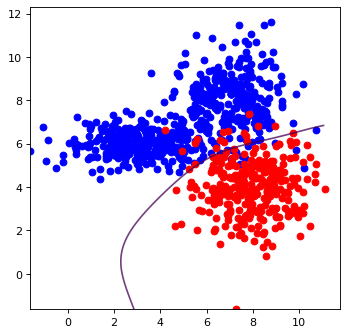

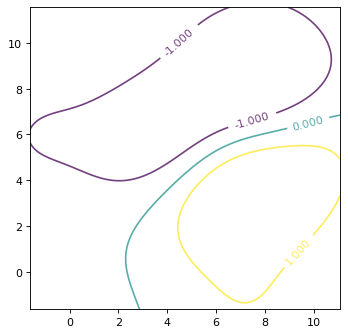

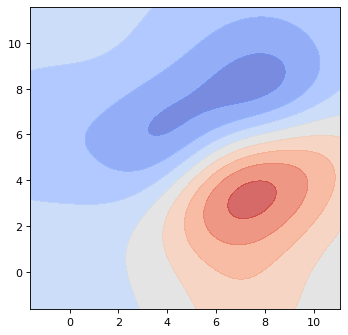

In [16]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.0, n_samples=300, n_features=2, n_classes=1)
X1[:,0] = 3. + X1[:,0]
X1[:,1] = 6. + X1[:,1]/2.5
X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X2[:,0] = 8. + X2[:,0]
X2[:,1] = 4. + X2[:,1]
X3, y3 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X3[:,0] = 7. + X3[:,0]
X3[:,1] = 8. + X3[:,1]
X = np.concatenate((X1, X2, X3))
y = np.concatenate((y1, - y2 + 1, y3))
y = 2*y-1
X, y = shuffle(X, y)
Xblue = X[y==-1]
Xred = X[y==1]

# Display
mySVC = svm.SVC(kernel='rbf')
mySVC.fit(X,y)
print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC);

These two last experiments illustrate that introducing complex kernels such as the rbf one is sometimes detrimental.

## <a id="sec7"></a>7. What about other uses?

SVMs can also be used to solve regression problems, although they are not often used for that in practice. The optimization problem differs a little but the main ideas remain. In scikit-learn, they can be accessed by using the svm.SVR class.

Similarly, one can derive a formulation of SVMs for density estimation.

SVMs easily support class weights and sample weights and can deal with unbalanced problems.

The general description of [SVMs in scikit-learn](http://scikit-learn.org/stable/modules/svm.html) is a good reminder on the versatility and the limitations of SVMs.

<div class="alert alert-success">
    
**In a nutshell:**
- Support Vector Machines try to separate data by maximizing a geometrical margin
- They are computed offline
- They offer a sparse, robust to class imbalance, and easy to evaluate predictor
- Kernels are a way of enriching (lifting) the data representation so that it becomes linearly separable
- SVMs + kernels offer a versatile method for classification, regression and density estimation
- [Documentation in scikit-learn](http://scikit-learn.org/stable/modules/svm.html)
</div>

## <a id="sec8"></a>8. Examples

## <a id="sec8-1"></a>8.1 Spam or ham?

Your turn to play: let's build a spam classifier using the ling-spam dataset.

In [17]:
from sys import path
path.append('../1 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()

In [18]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

In [19]:
spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain);

In [20]:
spam_svc.score(Xtest,ytest)

0.9921612541993281

In [21]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000)
    spam_svc = svm.SVC(kernel='linear', C=1.)
    spam_svc.fit(Xtrain,ytrain);
    score += [spam_svc.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

******************** done!


In [22]:
print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

Average generalization score: 0.9900895856662935
Standard deviation: 0.0030723728820423184


We've trained our model in the Tf-Idf data. Let's see how the model behaves on raw word counts.

In [23]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain)
spam_svc.score(Xtest,ytest)

0.9888017917133258

In [24]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000, feat='wordcount')
    spam_svc = svm.SVC(kernel='linear', C=1.)
    spam_svc.fit(Xtrain,ytrain);
    score += [spam_svc.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

******************** done!


In [25]:
print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

Average generalization score: 0.9865621500559911
Standard deviation: 0.004322566420071394


Let's keep the tf-idf classifier and use it to identify which are the misclassified emails (and find the confusion matrix by the way).

In [26]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)
spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain);

In [27]:
# Find misclassified examples
ypredict = spam_svc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

Misclassified messages indices: [243, 298, 438, 509, 523, 627, 649]


In [28]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[748   0]
 [  7 138]]


In [29]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_svc.predict(spam_data.tfidf[index,:]))
spam_data.print_email(index)

Prediction: [False]
email file: ../data/lingspam_public/bare/part6/spmsgb56.txt
email is a spam: True
Subject: uce : successful people only

unusual project , new ideas , not for everyone millionaire with non-profit foundation seeking successful people from = all walks of life = 20 for extended experiment in 1 ) creating great personal wealth for = participants and 2 ) for = 20 participation in a self study course in how to always have whatever is = wanted or desired , = 20 without limit or compromise . applicants must have prior success in = 20 some field , any field . teamwork skills and willingness to learn are = essential . must = 20 be willing and able to devote single-minded focus for six month = project . must possess = 20 desire for the freedom that personal wealth creates . must be willing to = work with large = 20 amounts of cash . there will be a short telephone interview to determine = potential = 20 suitability for the position . this project is not for everyone . = call 1

## <a id="sec8-2"></a> 8.2. NIST

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


<Figure size 432x288 with 0 Axes>

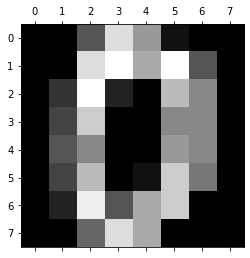

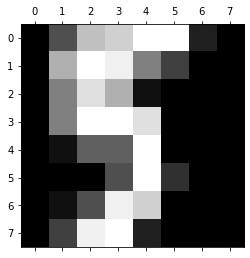

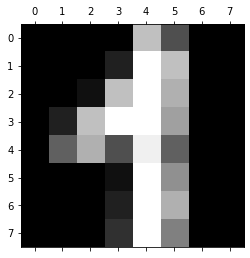

In [30]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

plt.gray();
plt.matshow(digits.images[0]);
plt.show();
plt.matshow(digits.images[15]);
plt.show();
plt.matshow(digits.images[42]);
plt.show();

In [31]:
from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [32]:
print(Xtrain.shape)
print(ytrain.shape)
digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
digits_svc.fit(Xtrain,ytrain)
prediction = digits_svc.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_svc.score(Xtest,ytest))

(1000, 64)
(1000,)
Generalization error: 0.030112923462986198
Generalization score: 0.9698870765370138


In [33]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
    digits_svc.fit(Xtrain,ytrain)
    score += [digits_svc.score(Xtest,ytest)]
    print('*',end='')
print(" done!")

******************** done!


In [34]:
print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

Average generalization score: 0.9871392722710162
Standard deviation: 0.0040438701052655755


Let's identify which are the misclassified images (and find the confusion matrix by the way).

In [35]:
# Retrain
Xtrain = X[:1000,:]
ytrain = y[:1000]
Xtest = X[1000:,:]
ytest = y[1000:]
digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
digits_svc.fit(Xtrain,ytrain);

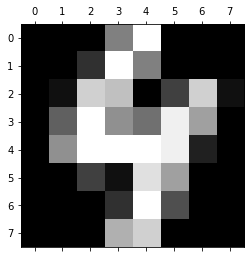

prediction on image number 1053 : [4]
correct label                : 4


In [36]:
# Examples
N = 1053
plt.matshow(digits.images[N]) 
plt.show() 
x = digits.data[N,:]
print("prediction on image number", N, ":", digits_svc.predict([digits.data[N,:]]))
print("correct label                :", digits.target[N])

In [37]:
# Find misclassified examples
ypredict = digits_svc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Itest = digits.images[1000:,:]
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
Imisclass = Itest[misclass,:]

In [38]:
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[78  0  0  0  1  0  0  0  0  0]
 [ 0 77  1  0  0  0  0  0  1  1]
 [ 0  0 76  1  0  0  0  0  0  0]
 [ 0  0  0 68  0  3  0  4  4  0]
 [ 0  0  0  0 79  0  0  0  0  4]
 [ 0  0  0  0  0 81  1  0  0  0]
 [ 0  1  0  0  0  0 79  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0 76  0]
 [ 0  0  0  1  0  1  0  0  0 79]]


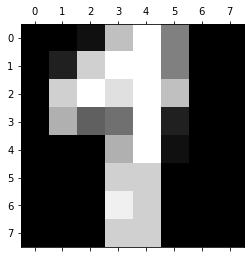

prediction on image number 2 : [2]
correct label                : 1


In [39]:
# Display misclassified examples
N = 2
plt.matshow(Imisclass[N]) 
plt.show() 
print("prediction on image number", N, ":", digits_svc.predict([Xmisclass[N,:]]))
print("correct label                :", ymisclass[N])